In [1]:
import train
import numpy as np
import api.capital_features_api as cf
import pandas as pd
import mplfinance as mpf
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from train import CustomSelectiveAccuracy

In [ ]:
train_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=1837497)
validation_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=1837499)
Y_ud_train = train_ud_data['upSignals']
Y_ud_val = validation_ud_data['upSignals']

In [ ]:
train_ud_dataset, validation_ud_dataset, scaler_ud = train.to_dataset(train_ud_data, validation_ud_data, Y_ud_train,
                                                                      Y_ud_val)
weights_ud = train.to_weights(Y_ud_train)
os.makedirs('./model/v8.80.5.200.1', exist_ok=True)
joblib.dump(scaler_ud, './model/v8.80.5.200.1/spy500-200_model_up_80_ty_scaler_ud.save')
train.save_scaler(scaler_ud, './model/v8.80.5.200.1/spy500-200_model_up_80_ty_scaler_ud.json')

In [ ]:
model_ud, callbacks_ud = train.get_model(5, 80, 'spy500-200_model_ud_80_ty')

In [ ]:
# initial_epoch=tu.find_last_epoch_txt_log('./log/epoch.log') + 1
his_ud = model_ud.fit(train_ud_dataset, epochs=1000, validation_data=validation_ud_dataset, verbose=1,
                      callbacks=callbacks_ud, class_weight=weights_ud)
model_ud.save('./model/v8.80.5.200.1/spy500-200_model_ud_80_ty.h5')
model_ud.save('./model/v8.80.5.200.1/spy500-200_model_ud_80_ty', save_format='tf')

In [ ]:
plt.plot(his_ud.history['accuracy'], label='accuracy')
plt.plot(his_ud.history['val_accuracy'], label='val_accuracy')
plt.plot(his_ud.history['loss'], label='loss')
plt.plot(his_ud.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
prediction_data = cf.get_prediction_data(cf.docker_prediction_data_url, train_config_id=1837497, start="2021-07-11",
                                         end=datetime.now().strftime("%Y-%m-%d"), code='SPY')
kline = cf.get_kline_histroy(cf.docker_kline_history_url, code="SPY", start="2021-07-11",
                             end=datetime.now().strftime("%Y-%m-%d"))
df = cf.his_to_df(kline)

In [ ]:
X_prediction_scaled = train.to_prediction_scaled(prediction_data, scaler_ud)
Y_ud_prediction = model_ud.predict(X_prediction_scaled)

In [ ]:
predictions_ud_series = pd.Series(Y_ud_prediction.flatten(), index=df.index)
buy_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
buy_signals[predictions_ud_series > 0.99] = df['low'][predictions_ud_series > 0.99] * 0.99
buy_markers = mpf.make_addplot(buy_signals, type='scatter', markersize=50, marker='^', color='g')

sell_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
sell_signals[predictions_ud_series < 0.01] = df['high'][predictions_ud_series < 0.01] * 1.01
sell_markers = mpf.make_addplot(sell_signals, type='scatter', markersize=50, marker='o', color='r')

mpf.plot(df, type='candle', style='charles', addplot=[buy_markers, sell_markers], volume=True, figsize=(24, 16))

In [2]:
# model_ud.load_weights('./epoch/spy500-200_model_ud_80_ty/epoch_432.ckpt')
model_ud = keras.models.load_model('./model/v8.80.5.200.1/spy500-200_model_ud_80_ty.h5')
scaler_ud = joblib.load('./model/v8.80.5.200.1/spy500-200_model_up_80_ty_scaler_ud.save')

In [3]:
test_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=2059160)
Y_ud_test = test_ud_data['upSignals']
test_dataset = train.to_test_dataset(test_ud_data, Y_ud_test, scaler_ud)

In [37]:
base_th = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
high_th = [0.99, 0.999, 0.9999, 0.99995, 0.99999]
thresholds = np.append(base_th, high_th)
results = train.evaluate(thresholds, model_ud, test_dataset)

3347/3347 [==============================] - 32s 9ms/step - loss: 1.0882 - custom_selective_accuracy: 1.0000


In [ ]:
plt.plot(thresholds, results['accuracies'], label='accuracy')
plt.legend()
plt.show()

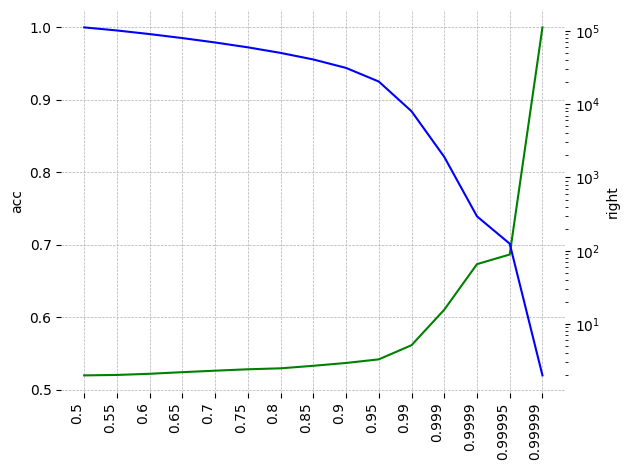

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(range(len(thresholds)), results['accuracies'], 'g-', label='Accuracy')
ax1.set_ylabel('acc')
ax1.set_xticks(range(len(thresholds)))
ax1.set_xticklabels(thresholds, rotation=90, ha='right')

ax2 = ax1.twinx()
ax2.plot(range(len(thresholds)), results['correct_predictions'], 'b-', label='right')
ax2.set_ylabel('right')
ax2.set_yscale('log')

ax1.grid(which='major', linestyle='--', linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

In [38]:
results['correct_predictions']

[<tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=111399.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=101167.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=90296.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=79634.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=69381.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=59558.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=50007.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=40687.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=31199.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=20340.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=8005.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=1909.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=295.0>,
 <tf.Variable 'correct_count:0' shape=() dtype=float32, numpy=125.

In [39]:
results['accuracies']

[0.5201258659362793,
 0.5207385420799255,
 0.5223225951194763,
 0.5245705246925354,
 0.5265989899635315,
 0.5285353064537048,
 0.5298642516136169,
 0.5333482027053833,
 0.5372376441955566,
 0.5422264933586121,
 0.5617149472236633,
 0.6106845736503601,
 0.6735159754753113,
 0.6868131756782532,
 1.0]